# Baseline model

This notebook contains the model that we will use as a baseline to compare all others. The architecture we will deploy is a U-Net, which is an encoder-encoder CNN with skip connections between layer $i$ and $n-i$. This model will be trained and tested over partitions of the the COCO 2014 training dataset. 

## Libraries import

In [21]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2lab, lab2rgb
from skimage import color

## Data import

We build a class to import the dataset and handle the COCO images in the desired formats.

In [92]:
class CocoDataset(Dataset):
    def __init__(self, root, transform = None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]            
        image = self.transform(Image.open(image_path).convert("RGB")) if self.transform else Image.open(image_path).convert("RGB")
        
        # if isinstance(image, torch.Tensor):
            # image = image.permute(1, 2, 0) # make it in format h w c, mainly for plotting
            
        return image
    
    def get_channels_for_image(self, index):
        image = self.__getitem__(index)
        image = np.array(image)
        if image.ndim == 3 and image.shape[0] == 3: 
            image = np.transpose(image, (1, 2, 0))
        lab_image = color.rgb2lab(image)
        l_channel = lab_image[:, :, 0] / 100  # Normalize L channel
        ab_channels = lab_image[:, :, 1:]  # AB channels as is
        return l_channel, ab_channels
    
    def plot_black_and_white(self, index):
        lab_image = self.get_channels_for_image(index)[0]
        plt.imshow(lab_image, cmap='gray')
        plt.axis('off') 
        plt.show()

Resize the images and convert them into tensors.

In [93]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to a fixed size
    transforms.ToTensor(),  # Convert the image to a tensor
])

Import the dataset.

In [94]:
dataset = CocoDataset(root='C:/Users/diego/coco/images/train2014/train2014', transform=transform)

Observe the dataset size.

In [95]:
print(f"Number of images: {len(dataset)}\nImage size: {dataset[0].shape}")

Number of images: 82783
Image size: torch.Size([3, 256, 256])


Let's look at the first image in the dataset.

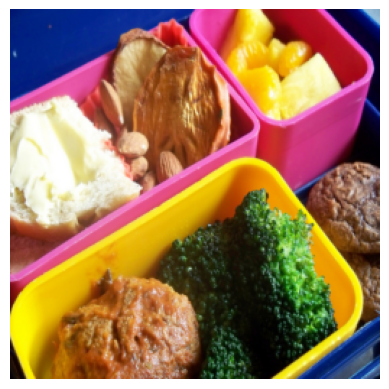

In [96]:
plt.imshow(dataset[0].permute(1, 2, 0)); # I make it in format h w c
plt.axis(False)
plt.show()

Let's convert this image in a black-and-white format using a previously defined function.

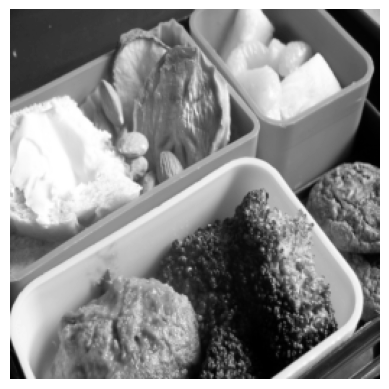

In [97]:
dataset.plot_black_and_white(0)

In [98]:
dataset.get_channels_for_image(0)

(array([[0.14122055, 0.14114124, 0.14715336, ..., 0.7056163 , 0.6929746 ,
         0.68185174],
        [0.13768035, 0.14242056, 0.14877686, ..., 0.7136075 , 0.7040635 ,
         0.68927073],
        [0.14242056, 0.14651713, 0.15252681, ..., 0.7194063 , 0.7071488 ,
         0.70193505],
        ...,
        [0.00919037, 0.02363869, 0.0466942 , ..., 0.37831584, 0.30248982,
         0.13002613],
        [0.00644865, 0.01801354, 0.03963055, ..., 0.17926663, 0.08962955,
         0.03659424],
        [0.00586555, 0.01447598, 0.02698513, ..., 0.05478144, 0.03203961,
         0.01690945]], dtype=float32),
 array([[[ 3.0678867e+01, -5.1174809e+01],
         [ 3.2031136e+01, -5.2491535e+01],
         [ 3.2548100e+01, -5.3440632e+01],
         ...,
         [-5.5047274e+00, -1.7536758e+01],
         [-6.3207150e+00, -1.7278313e+01],
         [-6.3077211e+00, -1.7323124e+01]],
 
        [[ 3.2272816e+01, -5.2414848e+01],
         [ 3.2411381e+01, -5.2929161e+01],
         [ 3.2974480e+01, -5.3817

## Data preparation

We split our dataset in train and test data.

In [79]:
def prepare_data(dataset):
    l_channels = []
    ab_channels = []
    for i in range(len(dataset)):
        l, ab = dataset.get_channels_for_image(i)
        l_channels.append(l)
        ab_channels.append(ab)
    return l_channels, ab_channels

In [80]:
l_channels, ab_channels = prepare_data(dataset)

ValueError: too many values to unpack (expected 2)